First, load the data,in this notebook we are using the Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". 


There are 3 datasets, in this work they will be combined together at species and genus level.

These 3 datasets comes from :
1) 96 sampels: Lloyd-Price J, Arze C, Ananthakrishnan AN, et al. Multi-omics of the gut microbial ecosystem in inflammatory bowel diseases. Nature 2019
2) 836 samples: Flores GE, Caporaso JG, Henley JB, et al. Temporal variability is a personalized feature of the human microbiome. Genome Biol 2014
3) 637 samples: Halfvarson J, Brislawn CJ, Lamendella R, et al. Dynamics of the human gut microbiome in inflammatory bowel disease. Nat Microbiol 2017

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric



2025-03-11 12:40:25.662595: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 12:40:25.666879: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 12:40:25.934667: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-11 12:40:25.952693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741711225.971703 2557318 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741711225.97

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

In [3]:
total_features_species = np.load('../data/total_features_species.npy')
total_features_genus = np.load('../data/total_features_genus.npy')
total_label= np.load('../data/total_label.npy')

In [4]:
print(total_features_species.shape)
print(total_features_genus.shape)

(1569, 283)
(1569, 220)


In [5]:
print(total_features_species)

[[0.00000000e+00 2.73776273e+01 2.27323259e+00 ... 0.00000000e+00
  9.88361996e-02 6.62202537e+00]
 [0.00000000e+00 9.49663099e+00 5.10571559e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.47664336e+02 3.94624672e-01 ... 7.89249345e-02
  0.00000000e+00 1.10494908e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [6]:
le = LabelEncoder()
y= le.fit_transform(total_label)

In [7]:
pd.DataFrame(y).value_counts()


0
0    867
1    702
Name: count, dtype: int64

### 2. Calculating H score for each OTU

In [8]:
taxlabels = ['Species','Genus']
feature_df_list = [pd.DataFrame(total_features_species,
                                         columns = [f"column_{i+1}" for i in range(total_features_species.shape[1])]),
                   pd.DataFrame(total_features_genus,
                                         columns = [f"column_{i+1}" for i in range(total_features_genus.shape[1])])]

In [9]:
feature_df_list[0]

,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,...,column_274,column_275,column_276,column_277,column_278,column_279,column_280,column_281,column_282,column_283
0,0.000000,27.377627,2.273233,1.284871,12.947542,1.186034,0.098836,0.000000,1696.721039,2.273233,...,0.0,0.098836,7.808060,0.0,0.000000,0.0,0.000000,0.000000,0.098836,6.622025
1,0.000000,9.496631,0.510572,0.306343,0.408457,0.510572,0.000000,0.000000,368.224208,4.084572,...,0.0,0.000000,3.063429,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.000000,347.664336,0.394625,536.452780,144.511555,0.236775,6.629694,0.000000,115.309329,85.949254,...,0.0,0.000000,1.104949,0.0,0.000000,0.0,0.000000,0.078925,0.000000,1.104949
3,0.000000,146.836982,0.000000,0.096794,1.064738,0.000000,0.000000,0.000000,4.646127,4.355744,...,0.0,0.096794,0.000000,0.0,0.000000,0.0,0.193589,0.000000,0.000000,0.096794
4,0.224605,32.118547,3.481381,0.786118,9.208814,0.786118,1.123026,0.000000,2000.109527,13008.460807,...,0.0,0.000000,7.636578,0.0,5.390525,0.0,0.000000,0.000000,0.112303,0.449210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,0.000000,0.225116,0.000000,0.000000,1.238138,0.000000,0.000000,0.000000,0.112558,0.000000,...,0.0,0.000000,3.489298,0.0,0.000000,0.0,0.337674,0.000000,0.000000,0.337674
1565,0.000000,0.389158,0.000000,0.000000,0.000000,0.000000,0.000000,0.389158,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


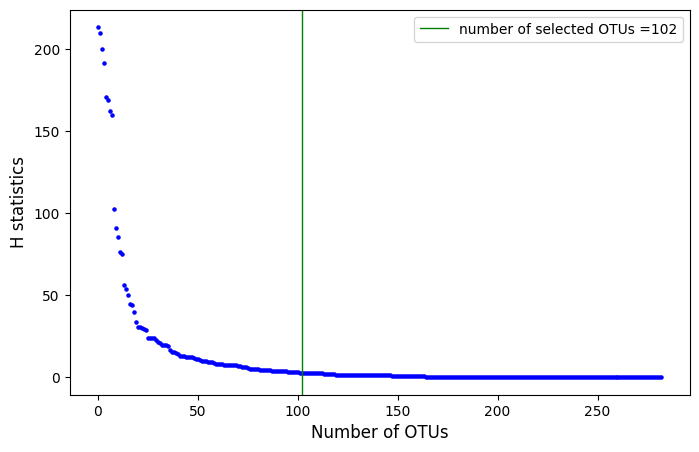

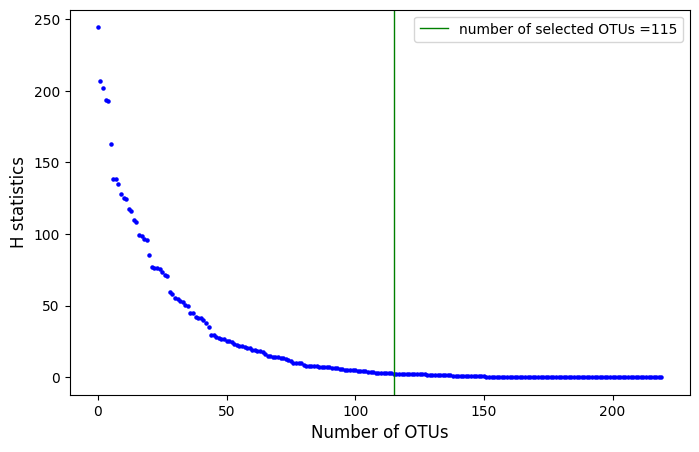

In [10]:
selectedresult_list = []
for feature_df in feature_df_list:
    selectedresult=FS.SelectMicro_fun(feature_df,y)
    selectedresult_list.append(selectedresult)

### Prepare other datasets

In [11]:
featurenames_full = [feature_df_list[0].columns,feature_df_list[1].columns]
selectedOTU_index_Lasso_list = []
selectedOTU_index_FS_lasso_list = []
selectedOTU_index_Lasso_FS_list = []

data_subset_list = []

for i, selectedresult in enumerate(selectedresult_list):
    selectedOTU_index_FS = selectedresult['selected_indices']

    data = selectedresult['relative_abundance_data']
    data_df = pd.DataFrame(data,columns = featurenames_full[i])
    X_FS = selectedresult['selected_data']
    X_FS_df =pd.DataFrame(X_FS,columns = selectedresult['selected_columnames'])
    
    X_lasso_ft,selectedOTU_index_Lasso  = RunML.LassoFS_CV(data,y)
    X_lasso_ft_df = pd.DataFrame(X_lasso_ft,columns = featurenames_full[i][selectedOTU_index_Lasso])
    selectedOTU_index_Lasso_list.append(selectedOTU_index_Lasso)

    X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML.LassoFS_CV(X_FS,y)
    selectedOTU_index_FS_lasso = selectedOTU_index_FS[xlabel_FS_lasso_ft0]
    X_FS_lasso_ft_df = pd.DataFrame(X_FS_lasso_ft,columns = featurenames_full[i][selectedOTU_index_FS_lasso])
    selectedOTU_index_FS_lasso_list.append(selectedOTU_index_FS_lasso)
    
    data_subset = {"AllFeatures":data_df, 
               "SelectMicro": X_FS_df,
               "Lasso_finetune":X_lasso_ft_df,
                "FS_Lassofinetune":X_FS_lasso_ft_df
              }
    data_subset_list.append(data_subset)

Best alpha: 0.005
Best alpha: 0.005
Best alpha: 0.005
Best alpha: 0.005


In [12]:
for data in data_subset_list:
    print(f'The shape of the original dataset is ',np.shape(data['AllFeatures']))
    print(f'The shape of the SelectMicro dataset is ',np.shape(data['SelectMicro']))
    print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(data['Lasso_finetune']))
    print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(data['FS_Lassofinetune']))

The shape of the original dataset is  (1569, 283)
The shape of the SelectMicro dataset is  (1569, 102)
The shape of the Lasso_finetune selected dataset is  (1569, 126)
The shape of the FS_Lasso_finetune selected dataset is  (1569, 84)
The shape of the original dataset is  (1569, 220)
The shape of the SelectMicro dataset is  (1569, 115)
The shape of the Lasso_finetune selected dataset is  (1569, 109)
The shape of the FS_Lasso_finetune selected dataset is  (1569, 85)


Species
AllFeatures


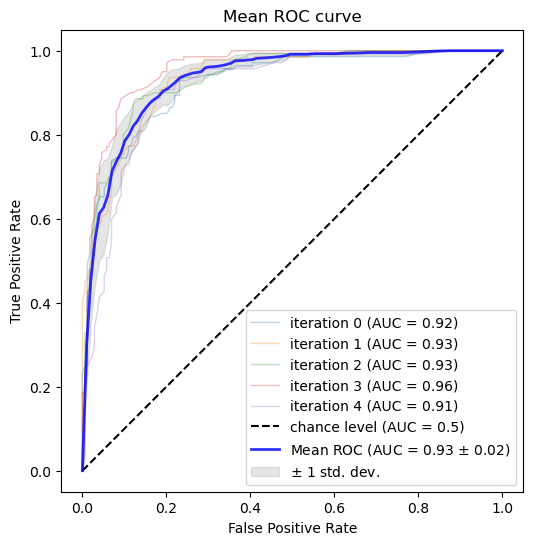

Accuracy: 0.856 (0.019), F1: 0.846 (0.020),MCC: 0.713 (0.038),AUC: 0.931 (0.015)


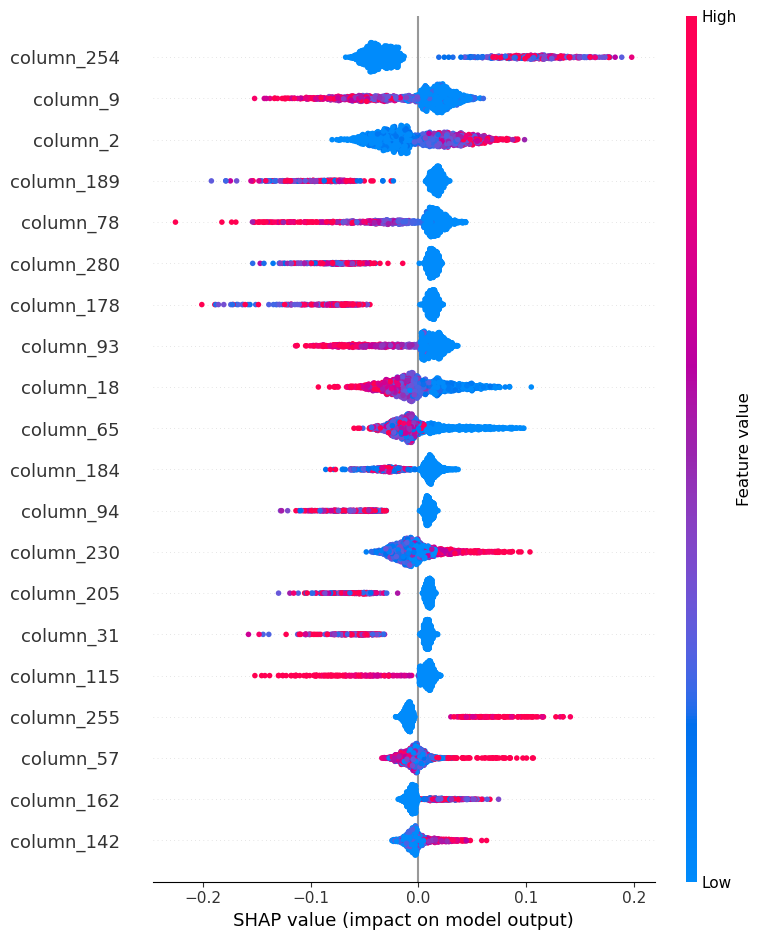

Species
SelectMicro


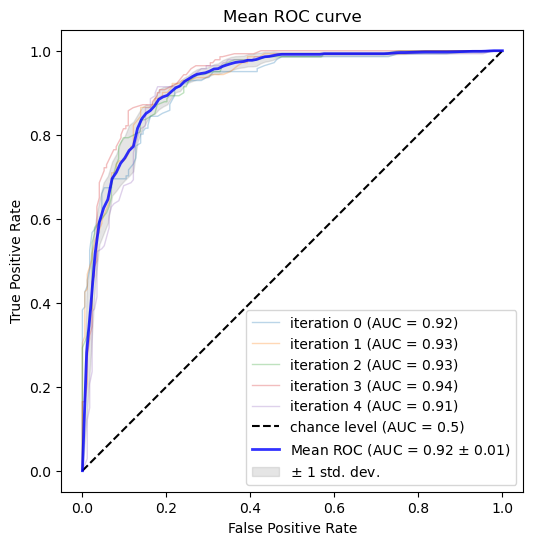

Accuracy: 0.852 (0.014), F1: 0.838 (0.015),MCC: 0.702 (0.027),AUC: 0.924 (0.009)


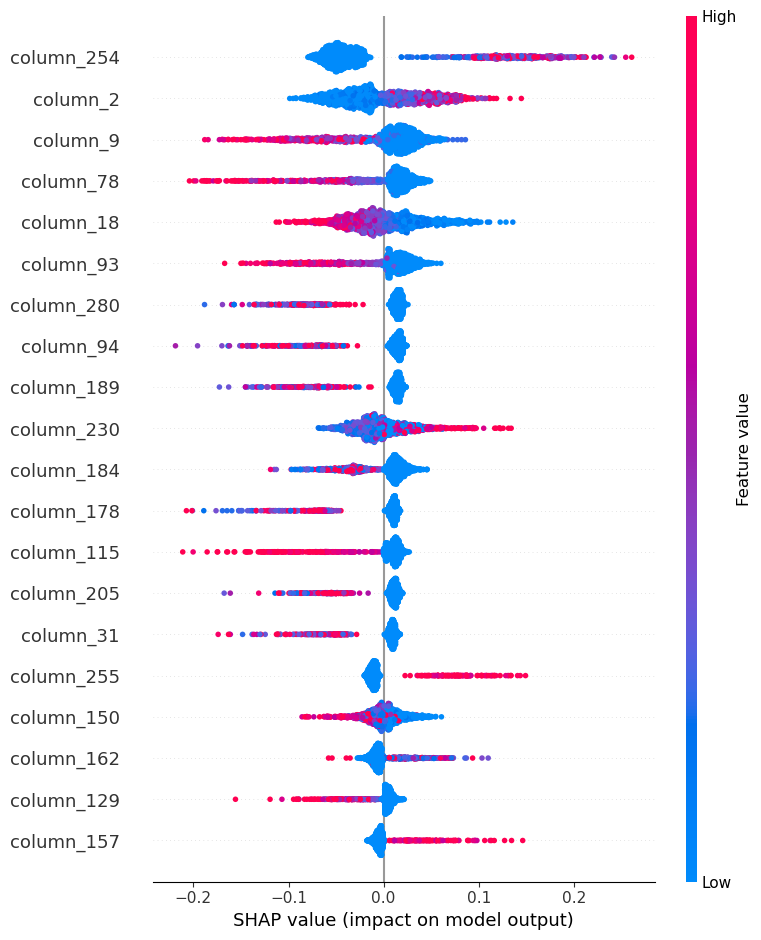

Species
Lasso_finetune


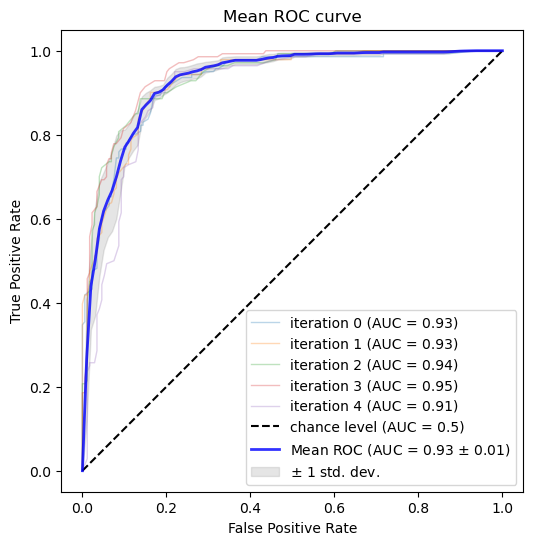

Accuracy: 0.864 (0.010), F1: 0.853 (0.010),MCC: 0.727 (0.020),AUC: 0.929 (0.014)


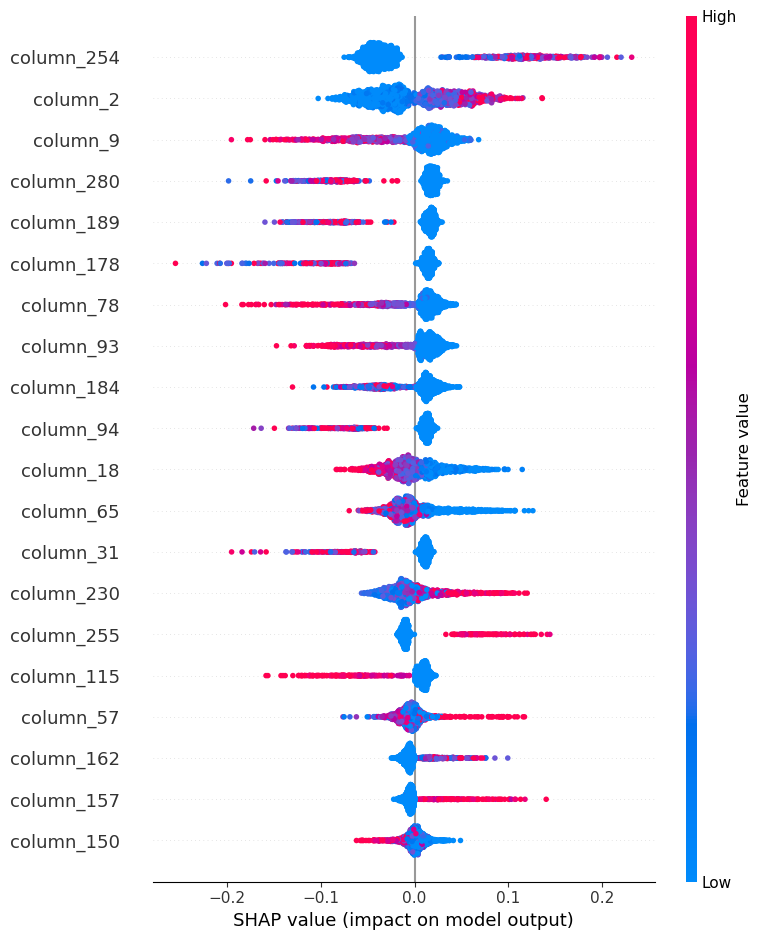

Species
FS_Lassofinetune


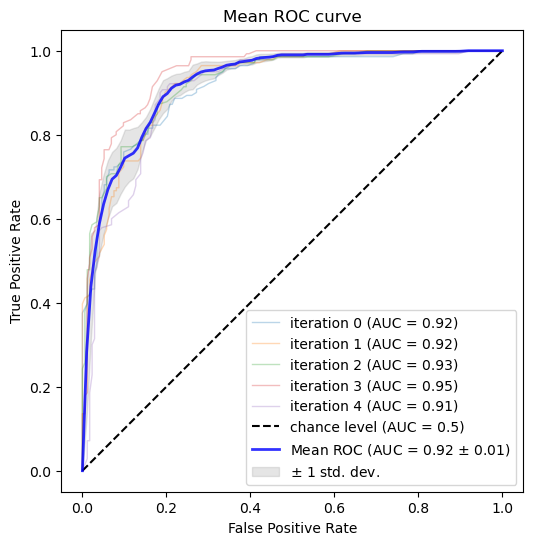

Accuracy: 0.836 (0.014), F1: 0.821 (0.016),MCC: 0.672 (0.028),AUC: 0.924 (0.014)


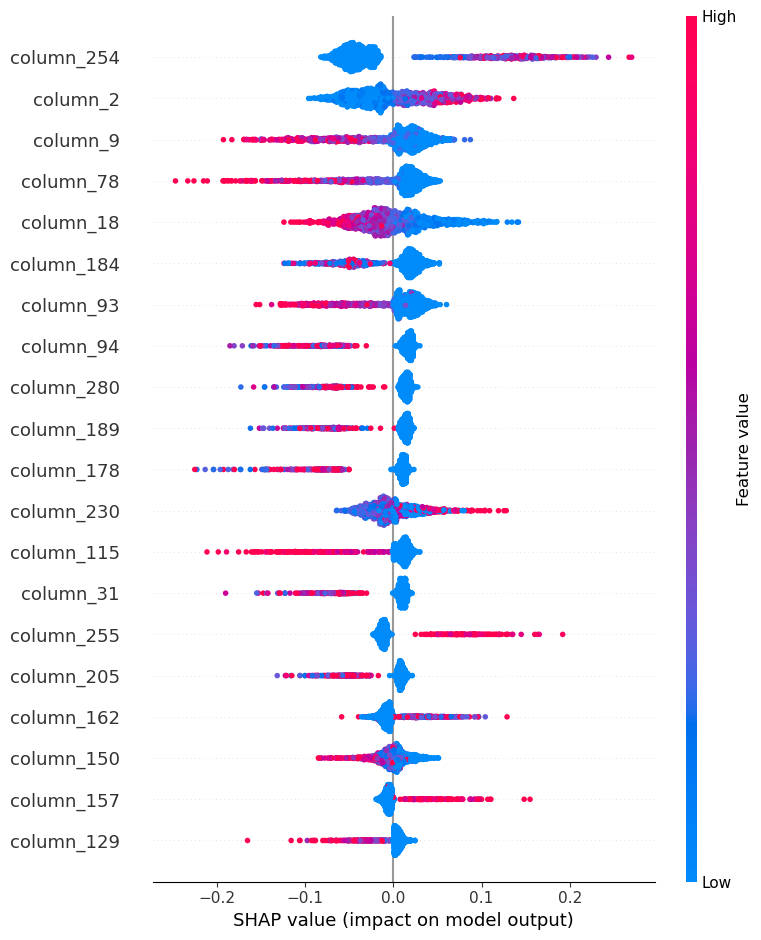

Genus
AllFeatures


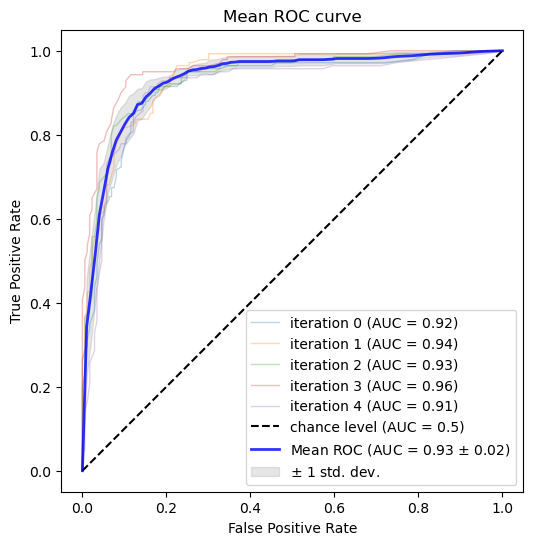

Accuracy: 0.862 (0.009), F1: 0.856 (0.009),MCC: 0.731 (0.019),AUC: 0.931 (0.017)


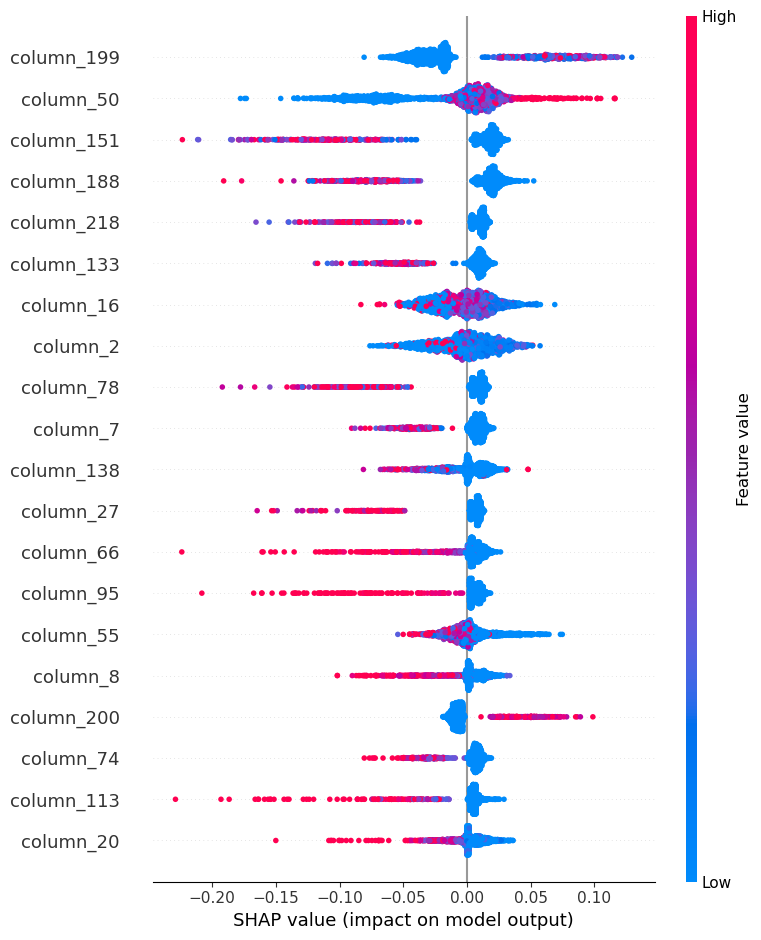

Genus
SelectMicro


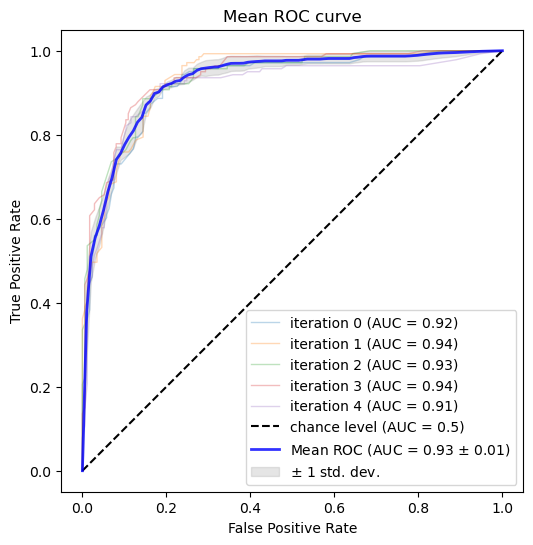

Accuracy: 0.857 (0.006), F1: 0.852 (0.006),MCC: 0.722 (0.012),AUC: 0.927 (0.010)


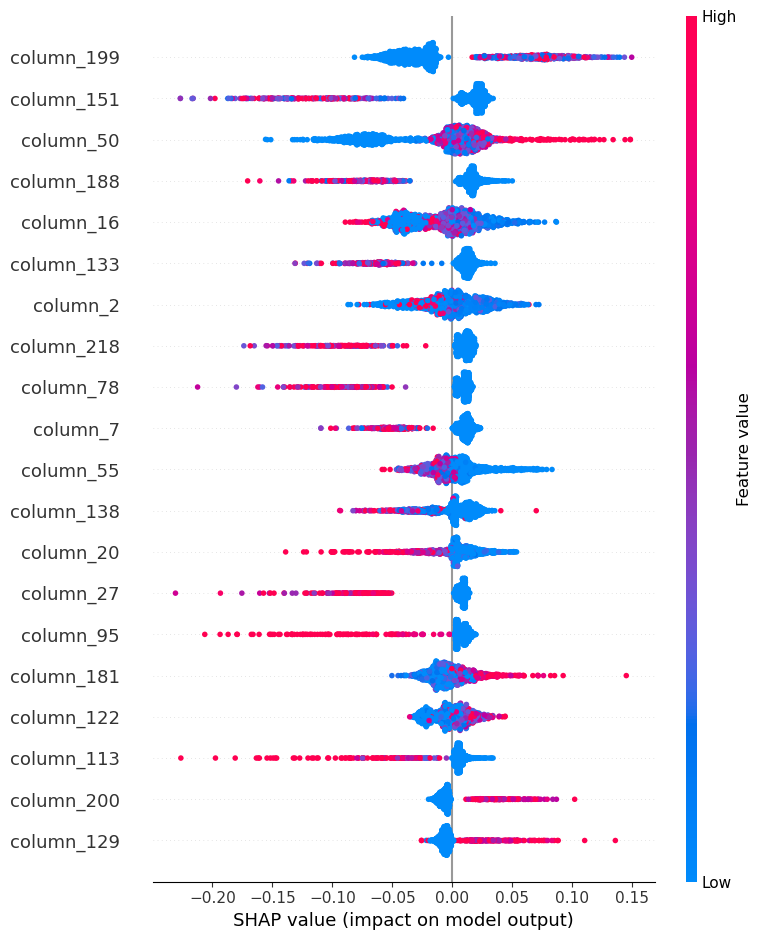

Genus
Lasso_finetune


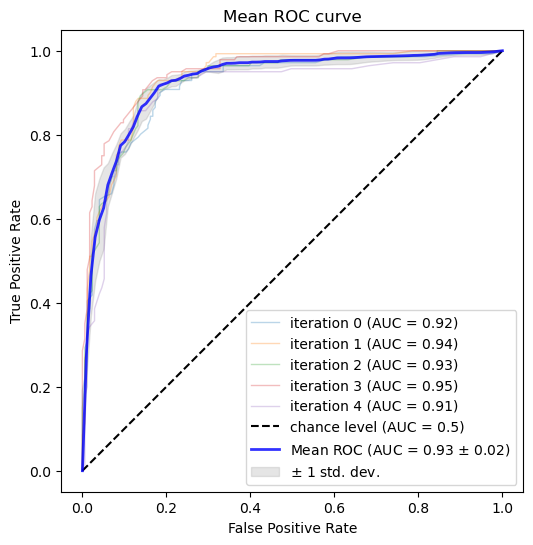

Accuracy: 0.857 (0.010), F1: 0.852 (0.010),MCC: 0.723 (0.019),AUC: 0.927 (0.015)


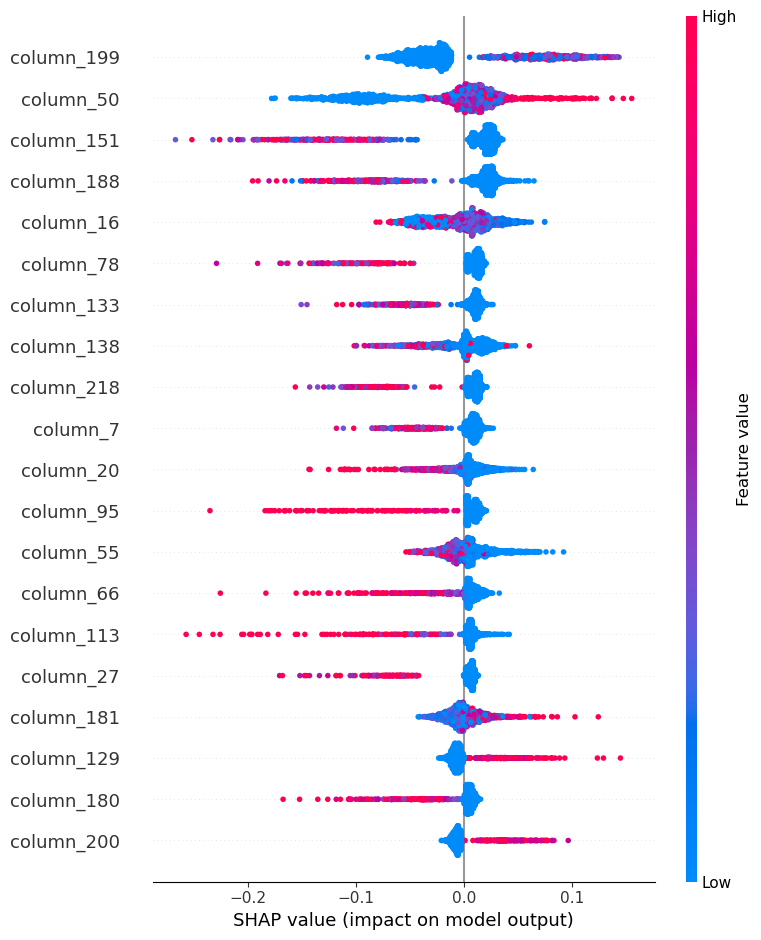

Genus
FS_Lassofinetune


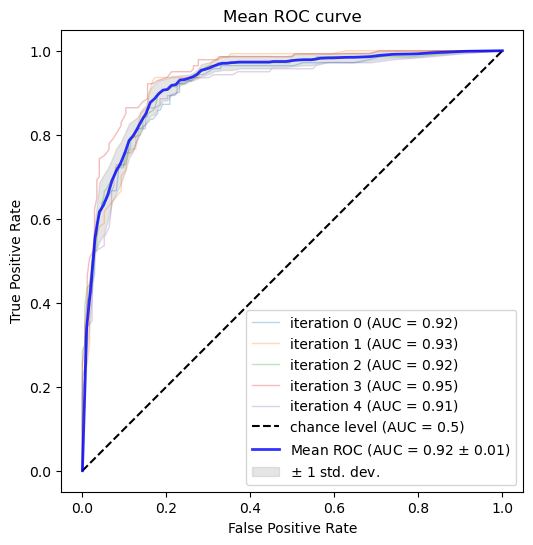

Accuracy: 0.853 (0.017), F1: 0.847 (0.017),MCC: 0.714 (0.033),AUC: 0.925 (0.013)


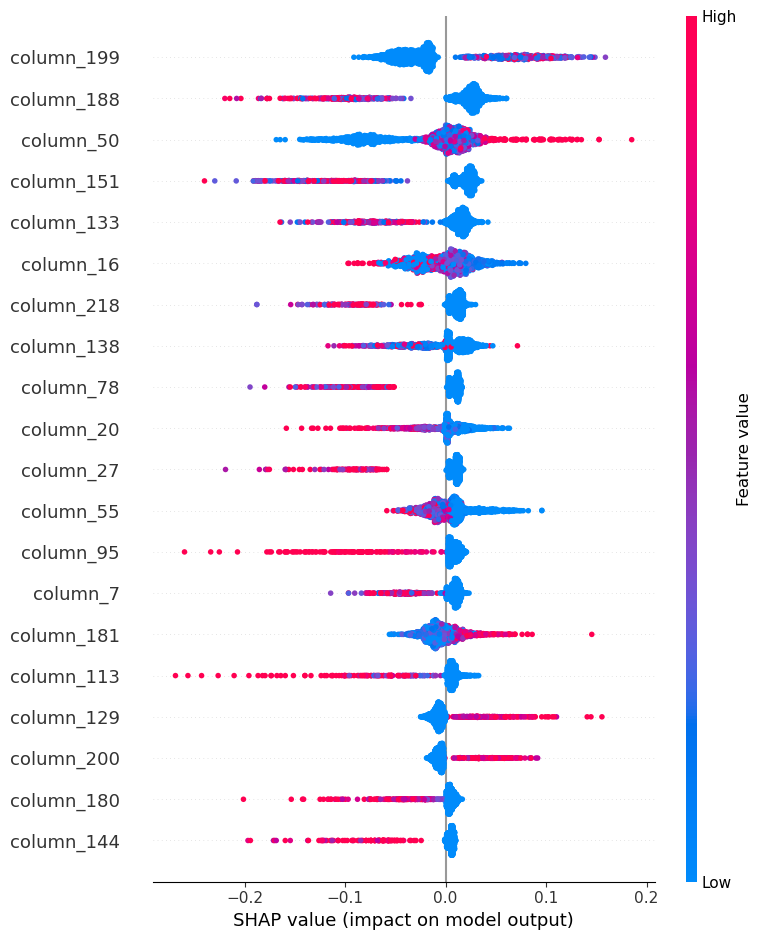

In [18]:
result_rf_list = []
for index, element in enumerate(taxlabels):
    for i, (key, value) in enumerate(data_subset_list[index].items()):
        print(element)
        print(key)
        result_rf_list.append(RunML.RF_model_SCV(value, y=y,plot=True, SMOTE=True,y_base = 1)
)


### Modeling

In [14]:
cls = ["RF","SVM", "NB","xgboost"]
for i , dataset  in enumerate(data_subset_list):
    print(f"Analysis for {taxlabels[i]}")
    dict_cm = RunML.runClassifier_FScompare(data_subsets= dataset,y= y,classifiers=cls)
    print(metric.metric_sum(dict_cm))

Analysis for Species
Classes: [0 1]


KeyError: "None of [Index([   0,    1,    2,    5,    6,    7,    8,    9,   10,   12,\n       ...\n       1556, 1557, 1558, 1559, 1561, 1563, 1564, 1565, 1567, 1568],\n      dtype='int64', length=1255)] are in the [columns]"

In [ ]:

for i , datasubset  in enumerate(data_subset_list):#[['Species','Genus']]
   
    for index, (key, value) in enumerate(datasubset.items()):# 5 different feature selection method
        print(f"Run RF model for: rank:{taxlabels[i]}, feature selection method: {key}")
        dict_cm = RunML.runClassifier_FScompare(data_subsets= dataset,y= y,classifiers=cls)
        print(metric.metric_sum(dict_cm))

0.9239945886114869
0.9077996715927751
0.9355911330049261
0.9113955408753096
0.7822736030828517
0.7974418890665353
0.7525862068965516
0.7484400656814449
0.7669281585466556
0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901477832513
0.9137902559867878
0.9185832000983888
0.9350018447915387
0.9254105090311987
0.9472290640394089
0.9119735755573907
0.8844340589513385
0.8945599147296357
0.8623563218390804
0.8826354679802956
0.8771676300578034
0.914237691140901
0.9293649817570615
0.891543513957307
0.9338259441707717
0.9108175061932287
0.7992046898700448
0.8698397081129832
0.7751847290640395
0.7847701149425288
0.7944673823286541
0.9056696593284959
0.9248554913294798
0.9013957307060756
0.9404351395730707
0.90532617671346
0.9192596236625261
0.9311892756118558
0.9224548440065682
0.9492200328407225
0.9040668868703551
0.8791046611732874
0.8906858524986676
0.8620279146141215
0.8747126436781609
0.8727497935590421
0.907514450867052
0.9311687779280942
0.894376026272578
0.9357963875205255

0.9224548440065682
0.9492200328407225
0.9040668868703551
0.8791046611732874
0.8906858524986676
0.8620279146141215
0.8747126436781609
0.8727497935590421
0.907514450867052
0.9311687779280942
0.894376026272578
0.9357963875205255
0.9058216350123864
0.787889968433567
0.8245603246833108
0.7623563218390804
0.7688423645320197
0.7700454170107349
0.9079244045422867
0.9318247038084696
0.897495894909688
0.9362479474548441
0.9042113955408753
0.9153650637477965
0.9296314516459641
0.9164203612479475
0.9462233169129721
0.9055532617671347
0.8793916287459518
0.8906038617636207
0.8620279146141215
0.8745073891625615
0.8726672171758877
0.9034149141147051
0.9225187553806419
0.8914614121510672
0.933128078817734
0.9111478117258464
0.7878079776985201
0.8308121182306399
0.7622947454844007
0.7707922824302135
0.7743393889347647
0.9095232238757021
0.9274791948509818
0.9003284072249589
0.9362889983579639
0.90355078447564
                  RF_Accuracy   RF_AUC    RF_mcc     RF_F    SVM_Accuracy  \
AllFeatures       

0.9095232238757021
0.9274791948509818
0.9003284072249589
0.9362889983579639
0.90355078447564
                  RF_Accuracy   RF_AUC    RF_mcc     RF_F    SVM_Accuracy  \
AllFeatures        0.865518    0.932579  0.735454  0.858295    0.799249     
SelectMicro        0.854051    0.928427  0.711464  0.845316    0.802428     
Lasso_finetune     0.854051    0.927640  0.713555  0.846757    0.794139     
FS_Lassofinetune   0.843208    0.925238  0.691481  0.835286    0.789036     
Lassofinetune_FS   0.850854    0.922639  0.707094  0.843535    0.789673     

                   SVM_AUC   SVM_mcc    SVM_F   CatBoost_Accuracy  \
AllFeatures       0.886037  0.602091  0.787254      0.850237        
SelectMicro       0.882510  0.609123  0.791247      0.849586        
Lasso_finetune    0.880231  0.593922  0.783777      0.838764        
FS_Lassofinetune  0.875856  0.584850  0.780034      0.836837        
Lassofinetune_FS  0.875840  0.585998  0.780559      0.832386        

                  CatBoost_AU

0.941151149920059
0.9301724137931034
0.9508210180623974
0.9159165978530142
0.895297831345058
0.9016931086787193
0.8641625615763545
0.8825533661740559
0.886478117258464
0.9131718115852909
0.9221088017054073
0.9127257799671593
0.9369868637110016
0.908670520231214
0.7635592178083876
0.7980568195793876
0.7479474548440066
0.7289408866995074
0.7598265895953757
0.9057926454310663
0.9230926905259705
0.9185139573070608
0.9346880131362889
0.9134186622625929
0.9175788135940639
0.9351043332103474
0.9306239737274219
0.950923645320197
0.9079066886870355
0.8889845447464436
0.8978395441315131
0.8662561576354679
0.8760673234811165
0.883402146985962
0.9186651908334358
0.9239945886114869
0.9077996715927751
0.9355911330049261
0.9113955408753096
0.7822736030828517
0.7974418890665353
0.7525862068965516
0.7484400656814449
0.7669281585466556
0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901477832513
0.9137902559867878
0.9185832000983888
0.9350018447915387
0.9254105090311987
0.9472290640394089

0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901477832513
0.9137902559867878
0.9185832000983888
0.9350018447915387
0.9254105090311987
0.9472290640394089
0.9119735755573907
0.8844340589513385
0.8945599147296357
0.8623563218390804
0.8826354679802956
0.8771676300578034
0.914237691140901
0.9293649817570615
0.891543513957307
0.9338259441707717
0.9108175061932287
0.7992046898700448
0.8698397081129832
0.7751847290640395
0.7847701149425288
0.7944673823286541
0.9056696593284959
0.9248554913294798
0.9013957307060756
0.9404351395730707
0.90532617671346
0.9192596236625261
0.9311892756118558
0.9224548440065682
0.9492200328407225
0.9040668868703551
0.8791046611732874
0.8906858524986676
0.8620279146141215
0.8747126436781609
0.8727497935590421
0.907514450867052
0.9311687779280942
0.894376026272578
0.9357963875205255
0.9058216350123864
0.787889968433567
0.8245603246833108
0.7623563218390804
0.7688423645320197
0.7700454170107349
0.9079244045422867
0.9318247038084696
0.897495894909688
0

0.9311687779280942
0.894376026272578
0.9357963875205255
0.9058216350123864
0.787889968433567
0.8245603246833108
0.7623563218390804
0.7688423645320197
0.7700454170107349
0.9079244045422867
0.9318247038084696
0.897495894909688
0.9362479474548441
0.9042113955408753
0.9153650637477965
0.9296314516459641
0.9164203612479475
0.9462233169129721
0.9055532617671347
0.8793916287459518
0.8906038617636207
0.8620279146141215
0.8745073891625615
0.8726672171758877
0.9034149141147051
0.9225187553806419
0.8914614121510672
0.933128078817734
0.9111478117258464
0.7878079776985201
0.8308121182306399
0.7622947454844007
0.7707922824302135
0.7743393889347647
0.9095232238757021
0.9274791948509818
0.9003284072249589
0.9362889983579639
0.90355078447564
                  RF_Accuracy   RF_AUC    RF_mcc     RF_F    SVM_Accuracy  \
AllFeatures        0.865518    0.932579  0.735454  0.858295    0.799249     
SelectMicro        0.854051    0.928427  0.711464  0.845316    0.802428     
Lasso_finetune     0.854051    0.9

0.941151149920059
0.9301724137931034
0.9508210180623974
0.9159165978530142
0.895297831345058
0.9016931086787193
0.8641625615763545
0.8825533661740559
0.886478117258464
0.9131718115852909
0.9221088017054073
0.9127257799671593
0.9369868637110016
0.908670520231214
0.7635592178083876
0.7980568195793876
0.7479474548440066
0.7289408866995074
0.7598265895953757
0.9057926454310663
0.9230926905259705
0.9185139573070608
0.9346880131362889
0.9134186622625929
0.9175788135940639
0.9351043332103474
0.9306239737274219
0.950923645320197
0.9079066886870355
0.8889845447464436
0.8978395441315131
0.8662561576354679
0.8760673234811165
0.883402146985962
0.9186651908334358
0.9239945886114869
0.9077996715927751
0.9355911330049261
0.9113955408753096
0.7822736030828517
0.7974418890665353
0.7525862068965516
0.7484400656814449
0.7669281585466556
0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901477832513
0.9137902559867878
0.9185832000983888
0.9350018447915387
0.9254105090311987
0.9472290640394089

# summary of results in latex
# in genus

In [ ]:
# plot the family 
for datatype, subset in data_subset_list[0].items():   
    RunML.plot_dim_reduction(subset, y, method='PCA',datalabel=datatype)

In [ ]:
# plot the genus 
for datatype, subset in data_subset_list[1].items():    
     RunML.plot_dim_reduction(subset, y, method='PCA',datalabel=datatype)

## compare the first 15 index

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# the   df with the largest H statistics features
entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]
df=pd.DataFrame(data=X_FS_15)


In [ ]:
# the column names of the featues
ASVs = cols_name
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]

In [ ]:
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="IBD",posText="IBD",negText="nonIBD",entries=entries)

In [ ]:
selectedASV_lasso = [cols_name[i] for i in xlabel_lasso]
RunML.plotPresenseRatio(X_lasso,targetLabel,selectedASV_lasso,posLabel="IBD",posText="IBD",negText="nonIBD",entries=len(selectedASV_lasso))

In [ ]:
selectedASVs

In [ ]:
qitta_combine[['Diagnosis','X4414821']].value_counts()

In [ ]:
selectedASV_lasso